# Vector Spaces: Part I, 'The Curse of Dimensionality'


Much of statistical learning relies on the ability to represent data observations (measurements) in a space comprising relevant dimensions (features). Often, the number of relevant dimensions is quite small; if you were trying to discern a model that described the area of a rectangle, observations of only two features (length and width) would be all you needed. [Fisher's well-known iris dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) comprises 150 measurements of only three features 📊 

In some cases - particularly with text analysis - the dimensionality of the space can grow much faster. In many approaches to text analysis, the process to get from a text corpus to numerical feature vectors involves a few steps. Just as an exapmle, one way to do this is to: 

1. **break the corpus into documents** e.g. each on a new line of an input file
2. **parse the document into tokens** e.g. split words on whitespace
3. **construct a feature vector for each document**

One way to accomplish the final step is to consider each token (ie word) as a unique dimension, and the count of each word per document as the magnitude along the corresponding dimension. There are certainly other ways to define each of these steps (and more subtle details to consider within each), but for now, we'll consider this simple one. 

Using exactly this approach, constructing a vector space from just a few minutes of Tweets (each Tweet considered a document) leads to a space with hundreds of thousands of features! In this high-dimensional vector space, it becomes easy for us to be misled by our intuition for statistical learning approaches in more "human" dimensions e.g. one-, two- and three-dimensional spaces. At this point, many people will cite the **"curse of dimensionality."** 


> There are multiple phenomena referred to by this name in domains such as numerical analysis, sampling, combinatorics, machine learning, data mining, and databases. **The common theme of these problems is that when the dimensionality increases, the volume of the space increases so fast that the available data become sparse.** This sparsity is problematic for any method that requires statistical significance. In order to obtain a statistically sound and reliable result, **the amount of data needed to support the result often grows exponentially with the dimensionality.** Also organizing and searching data often relies on detecting areas where objects form groups with similar properties; **in high dimensional data however all objects appear to be sparse and dissimilar in many ways which prevents common data organization strategies from being efficient.**

- [Wikipedia](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

This "curse of dimensionality" refers to a few related, but distinct challenges with data for statistical learning in high dimensions:

- "increasing dimensions decrease the power of a test statistic" [ref](http://stats.stackexchange.com/a/30299)
- "Intuition fails us in high dimensions" [ref](http://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
- sparse data is increasingly found in the corners/shell of high-dimensional space (this notebook!) 

I wanted to build more intuition around thinking, visualizing, and generally being more aware of how these phenomena affect our typical kinds of analyses; this notebook is a first step, primarily focused on **building an intuition for inspecting and thinking about ways to inspect spaces when we can longer just plot them.** 

Along the way, I learned a number of new things, and aim to explore them in follow up pieces.

*Note: Beware that there are a lot of reused variable names in this notebook. If you get an unexpected result, or an error, be sure to check that the appropriate data generation step was run!*


## Take-aways

These are the two high-level objectives we'll aim for:

- concepts for inspecting data in high dimensions
- illustrations of how high dimensionality squeezes data "density profile" to edges
    - kmeans `~O(d)`
    - "statistical significance"


In [1]:
import copy
try:
    import ujson as json
except ImportError:
    import json    
import math
import operator
import random

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy.linalg import norm as np_norm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance as spd
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set_style('whitegrid')
%matplotlib inline

# Simple, visualizable spaces

We'll start by exploring some approaches to thinking about and inspecting data in spaces that we can comprehend without much effort.

## Normal distributions in 2D

In [2]:
# number of data points
n = 1000

# array of continuous values, randomly drawn from standard normal in two dimensions
X = np.array(np.random.normal(size=(n,2)))

# seaborn plays really nicely with pandas
df = pd.DataFrame(X, columns=['x0','x1'])

df.tail()

,x0,x1
995,-0.760630,-0.043578
996,0.781632,-2.448517
997,-0.144603,-0.118683
998,1.978438,-0.173099
999,-0.984071,-1.152468


We have a 2-dimensional feature space containing 1000 pieces of data. Each coordinate is orthogonal, and we can equivalently think about each data point being represented by a vector from the origin [ (0,0) in 2-dimensional space ], to the point defined by [x0, x1].

Since we only have two dimensions, we can look at the bivariate distribution quite easily using `jointplot`. Seaborn also gives us some handy tools for looking at the univariate distributions at the same time 🙌🏼

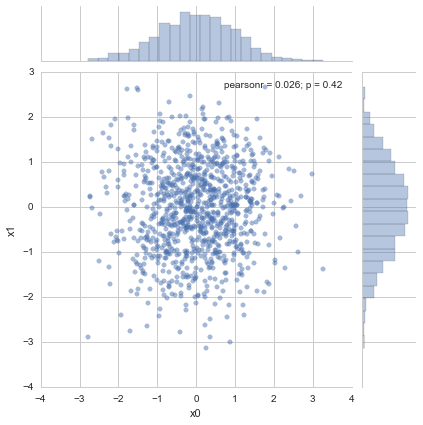

In [3]:
sns.jointplot(data=df, x='x0', y='x1', alpha=0.5)

Another distribution that can provide some hints about the structure of data in a multi-dimensional vector space, is the pairwise inter-point distance distribution for all points in the data. Here's a function that makes this a little cleaner.

In [4]:
def in_sample_dist(X, n):
    """Create a histogram of pairwise distances in array X, using n bins."""
    plt.figure(figsize=(15,6))

    # use scipy's pairwise distance function for efficiency
    plt.hist(spd.pdist(X), bins=n, alpha=0.6)

    plt.xlabel('inter-sample distance')
    plt.ylabel('count')    

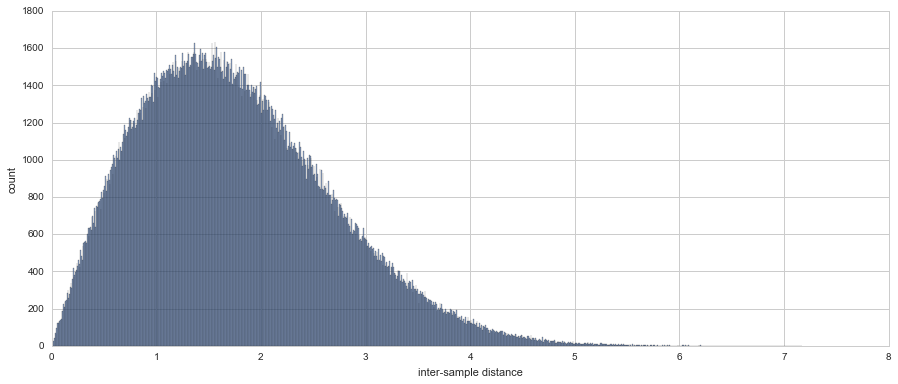

In [5]:
in_sample_dist(X,n)

In unsupervised statistical learning, we're often interested in the existence of "clusters" in data. Our intuition in low dimensions can be helpful here. In order to identify and label a grouping of points as being unique from some other grouping of points, there needs to be a similarity or "sameness" metric that we can compare. One such measure is simply the distance between all of the points. If a group of points are all qualitatively closer to each other than another group of points, then we might call those two groups unique clusters. 

If we look at the distribution of inter-point distances above, we see a relatively smooth distribution, suggesting that no group of points is notably closer or further than another other group of points. We'll come back to this idea, shortly. (The inspiration for this approach is found here: [pdf](http://www-users.cs.umn.edu/~kumar/papers/high_dim_clustering_19.pdf))



Above, the bivariate pairplot works great for displaying our data when it's in two dimensions, but you can probably imagine that even in just d=3 dimensions, looking at this distribution of data will be really hard. So, I want to create a metric that gives us a feel for where the data is located in the vector space. There are *many* ways to do this. For now, I'm going to consider the **euclidean distance cumulative distribution function\***. Remember that the [euclidean distance](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html#scipy.spatial.distance.euclidean) is the $L_{2}$ norm $dist(p,q) = \sqrt{ \sum_{i=1}^{d} (q_{i}-p_{i})^{2} }$ where `d` is the dimensionality of the space. ([Wiki](https://en.wikipedia.org/wiki/Euclidean_distance))


\*in fact, even in the course of developing this notebook, I learned that this is not a terribly great choice. But, hey, you have to start somewhere! `¯\_(ツ)_/¯` 

In [6]:
def radius(vector):
    """Calculate the euclidean norm for the given coordinate vector."""    
    origin = np.zeros(len(vector))
    # use scipy's distance functions again! 
    return spd.euclidean(origin, vector)

In [7]:
# use our function to create a new 'r' column in the dataframe
df['r'] = df.apply(radius, axis=1)

df.head()

,x0,x1,r
0,-0.552261,-0.021335,0.552673
1,1.164403,-0.833889,1.432203
2,0.023554,0.360262,0.361031
3,-1.498556,2.584151,2.987224
4,1.308307,1.347345,1.878032


There are a couple of ways that I want to visualize this radial distance. **First**, I'd like to see the univariate distribution (from 0 to `max(r)`), and **second**, I'd like to see how much of the data is at a radius less than or equal to a particular value of `r`. To do this, I'll define a plotting function that takes a dataframe as shown above, and returns plots of these two distributions as described.

There's a lot of plotting hijinks in this function, so first just look at the output and see if it makes some sense. Then we can come back and dig through the plotting function.

In [8]:
def kde_cdf_plot(df, norm=False, vol=False):
    """Display stacked KDE and CDF plots."""
    
    assert 'r' in df, 'This method only works for dataframes that include a radial distance in an "r" column!'
    
    if norm:
        # overwrite df.r with normalized version
        df['r'] = df['r'] / max(df['r'])
        
    fig, (ax1, ax2) = plt.subplots(2,1, 
                                   sharex=True, 
                                   figsize=(15,8)
                                  )
    # subplot 1
    sns.distplot(df['r'], 
                 hist=False, 
                 rug=True, 
                 ax=ax1
                )
    ax1.set_ylabel('KDE')
    ax1.set_title('n={} in {}-d space'.format(len(df), df.shape[1] - 1) )

    # subplot 2
    if vol:
        raise NotImplementedError("Didn't finish implementing this volume normalization!")
        dim = df.shape[1] - 1
        df['r'].apply(lambda x: x**dim).plot(kind='hist', 
                                               cumulative=True, 
                                               normed=1, 
                                               bins=len(df['r']), 
                                               histtype='step', 
                                               linewidth=2,
                                               ax=ax2
                                              )

        ax2.set_ylabel('CDF')
        plt.xlim(0, .99*max(df['r'])**dim)        
        xlab = 'volume fraction'        
    else:
        df['r'].plot(kind='hist', 
                       cumulative=True, 
                       normed=1, 
                       bins=len(df['r']), 
                       histtype='step', 
                       linewidth=2,
                       ax=ax2
                      )

        ax2.set_ylabel('CDF')
        plt.xlim(0, .99*max(df['r']))
        
        xlab = 'radial distance'
    if norm:
        xlab += ' (%)'
    plt.xlabel(xlab)

Now, let's see these distributions for the 2-dimensional array we created earlier.

/Users/jmontague/.virtualenvs/py34-data/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


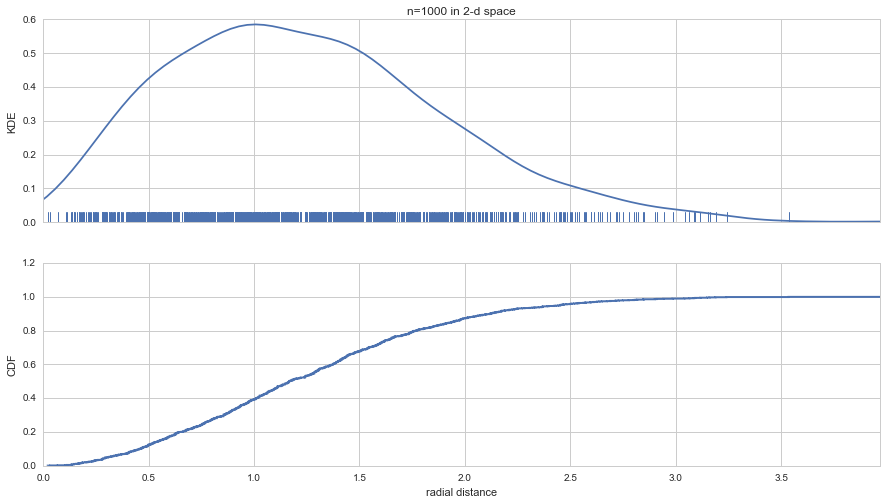

In [9]:
kde_cdf_plot(df)

As a reminder: 

- the **kernel density estimate** (KDE) is a nice visualization of the "density profile", created by assuming there exists a standard normal at each data point, summing all of these curves, and then normalizing the total under-curve area to 1. [The `seaborn` docs](https://stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html#kernel-density-estimaton) have a nice illustration of this technique. The ticks on the bottom are called a "rug plot", and are the values of the data (values of `r`)
- the **cumulative distribution function** (CDF) is a measure of the fraction of values which have a value equal to, or lesser than, the specified value, $CDF_{X}(x)=P(X \le x)$. For the purpose of this session, I want to use this particular to highlight where the observed data is, relative to the "radius" of the entire space. The value of the CDF is the fraction of data contained at an equal or lesser "radius" value (in d dimensions). 

## Blobs in 2D

Let's add a bit of complexity to the examples above by making the data slightly more irregular: we'll use ``sklearn``'s blob constructor.

In [10]:
# data points, dimensions, blob count
n = 1000
dims = 2
blobs = 5

# note: default bounding space is +/- 10.0 in each dimension
X, y = make_blobs(n_samples=n, n_features=dims, centers=blobs)

In [11]:
# convert np arrays to a df, auto-label the columns
X_df = pd.DataFrame(X, columns=['x{}'.format(i) for i in range(X.shape[1])])

X_df.head()

,x0,x1
0,3.194578,-4.471401
1,0.684149,-5.857409
2,-2.968475,-1.279401
3,4.522980,7.986286
4,-5.968381,8.288460


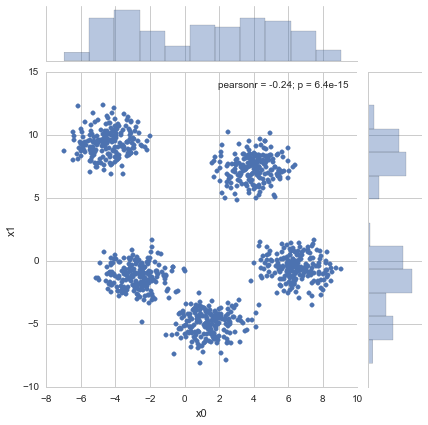

In [12]:
sns.jointplot(data=X_df, x='x0', y='x1')

In [13]:
X_df['r'] = X_df.apply(radius, axis=1)

#X_df.head()

This time, we'll incorporate one extra kwarg in the `kde_cdf_plot` function: `norm=True` displays the x axis (radial distance) as a fraction of the maximum value. This will helpful when we're comparing spaces of varying radial magnitude.

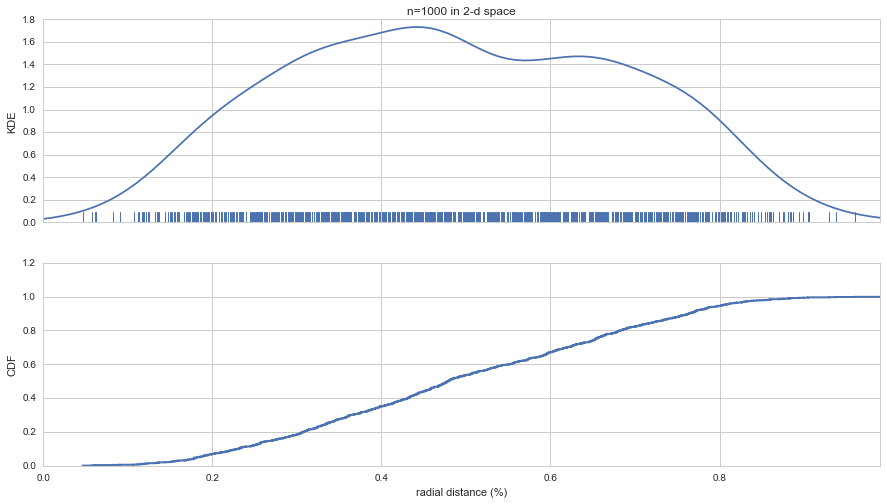

In [14]:
kde_cdf_plot(X_df, norm=True)

As a start, notice that the radius CDF for this data has shifted to the right. At larger `r`, we're closer to the "edge" of the space containing our data. The graph will vary with iterations of the data generation, but should consistently be shifted to the right relative to the 0-centered standard normal distribution.

Now let's look at the inter-sample distance distribution. Remember that this data is explicitly generated by a mechanism that includes clusters, so we should not see a nice uniform distribution.

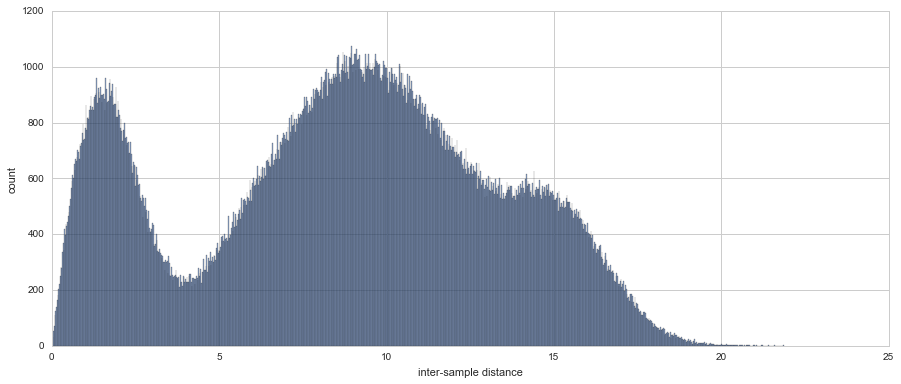

In [15]:
in_sample_dist(X,n)

Sure enough, we can see that there are in fact some peaks in the inter-sample distance. This makes sense, because we know that the data generation process encoded that exact idea. Since we're intentionally using a data generation process that builds in clusters, we'll always see a peak on the low end of the x axis... each cluster is created with a low (and similar) intra-cluster distance. The other, larger peaks, will illustrate the relationships between the clusters.

We may not see precisely the same number of peaks as were specified in the blob creation, though, because we know that sometimes the blobs will be on top of each other and will "look" like one cluster. Compare the peaks of this distribution with the pairplot we created with the same data. 

## Blobs in 3D

Let's increase the dimension count by one, to 3, just about the limit of our intuition's abilities. To make the data generation process a bit more reusable, we'll use a function to get the data array and corresponding dataframes.

In [18]:
def make_blob_df(n_points=1000, dims=2, blobs=5, bounding_box=(-10.0, 10.0)):
    """Function to automate the np.array blob => pd.df creation and r calculation."""
    # nb: default bounding space is +/- 10.0 in each dimension
    X, y = make_blobs(n_samples=n_points, n_features=dims, centers=blobs, center_box=bounding_box)

    # make a df, auto-label the columns
    X_df = pd.DataFrame(X, columns=['x{}'.format(i) for i in range(X.shape[1])])
    X_df_no_r = copy.deepcopy(X_df)
    
    # add a radial distance column
    X_df['r'] = X_df.apply(radius, axis=1)

    return X, X_df, X_df_no_r, y

In [19]:
n = 1000
dims = 3
blobs = 5


X, X_df, X_df_no_r, y = make_blob_df(n, dims, blobs)

X_df.head()
#X_df_no_r.head()

,x0,x1,x2,r
0,3.230195,3.536956,4.384346,6.493590
1,4.304887,1.638610,2.046219,5.040249
2,4.514390,6.489449,3.025317,8.464349
3,5.682426,7.029903,4.256496,9.991359
4,-1.417735,4.502991,-1.648178,5.000339


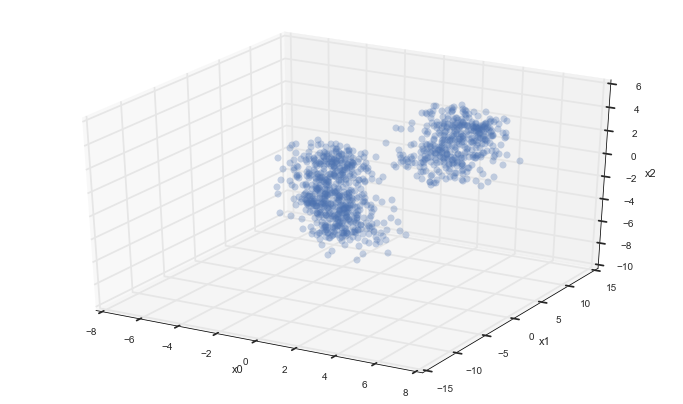

In [20]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_df['x0'],X_df['x1'],X_df['x2'],'o', alpha=0.3)

ax.set_xlabel('x0'); ax.set_ylabel('x1'); ax.set_zlabel('x2')

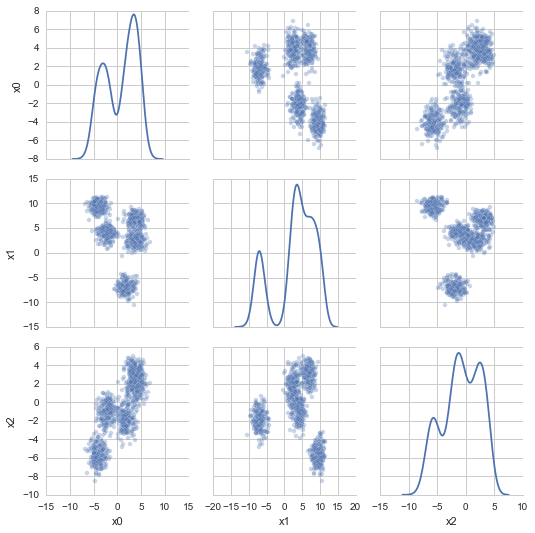

In [21]:
sns.pairplot(X_df_no_r, plot_kws=dict(alpha=0.3), diag_kind='kde')

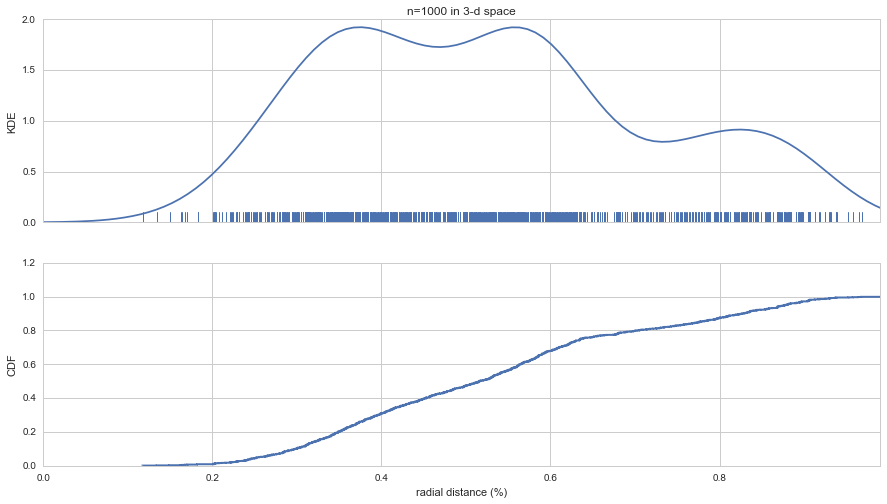

In [22]:
kde_cdf_plot(X_df, norm=True)

Again, compare this CDF to the 2-d case above; note that the data is closer to the "edge" of the space.

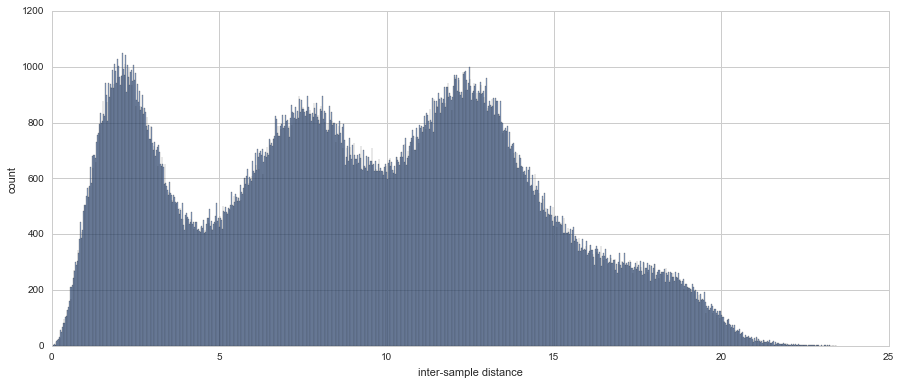

In [23]:
in_sample_dist(X,n)

## Higher-dimensional blobs

Ok, let's jump out of the space where we can easily visualize the data. Let's now go to d=10. While we can still look at pairwise coordinate locations, we can't see the whole space at once anymore. Now we'll rely on our other plots for intuition of the space profile.

In [24]:
n = 1000
dims = 10
blobs = 5


X, X_df, X_df_no_r, y = make_blob_df(n, dims, blobs)

X_df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,r
0,-6.391177,-6.763341,9.550505,4.926454,-6.202411,-4.250248,-5.753616,2.978710,-5.398746,7.886214,19.797024
1,-3.167697,1.432007,5.871776,-1.686182,10.693245,-1.633358,0.275762,7.531419,-2.897163,-0.276121,15.221281
2,1.022232,1.195789,4.843115,-3.467673,8.825947,-3.451882,0.571718,6.281954,-2.056217,-0.415408,13.113299
3,-8.514752,-5.997685,9.354318,5.728136,-8.472912,-6.589185,-8.345721,1.007842,-5.400010,7.042799,22.213140
4,-7.985683,-6.823827,9.805556,6.532804,-9.067354,-7.325907,-7.879309,2.257284,-4.319450,6.710113,22.713655


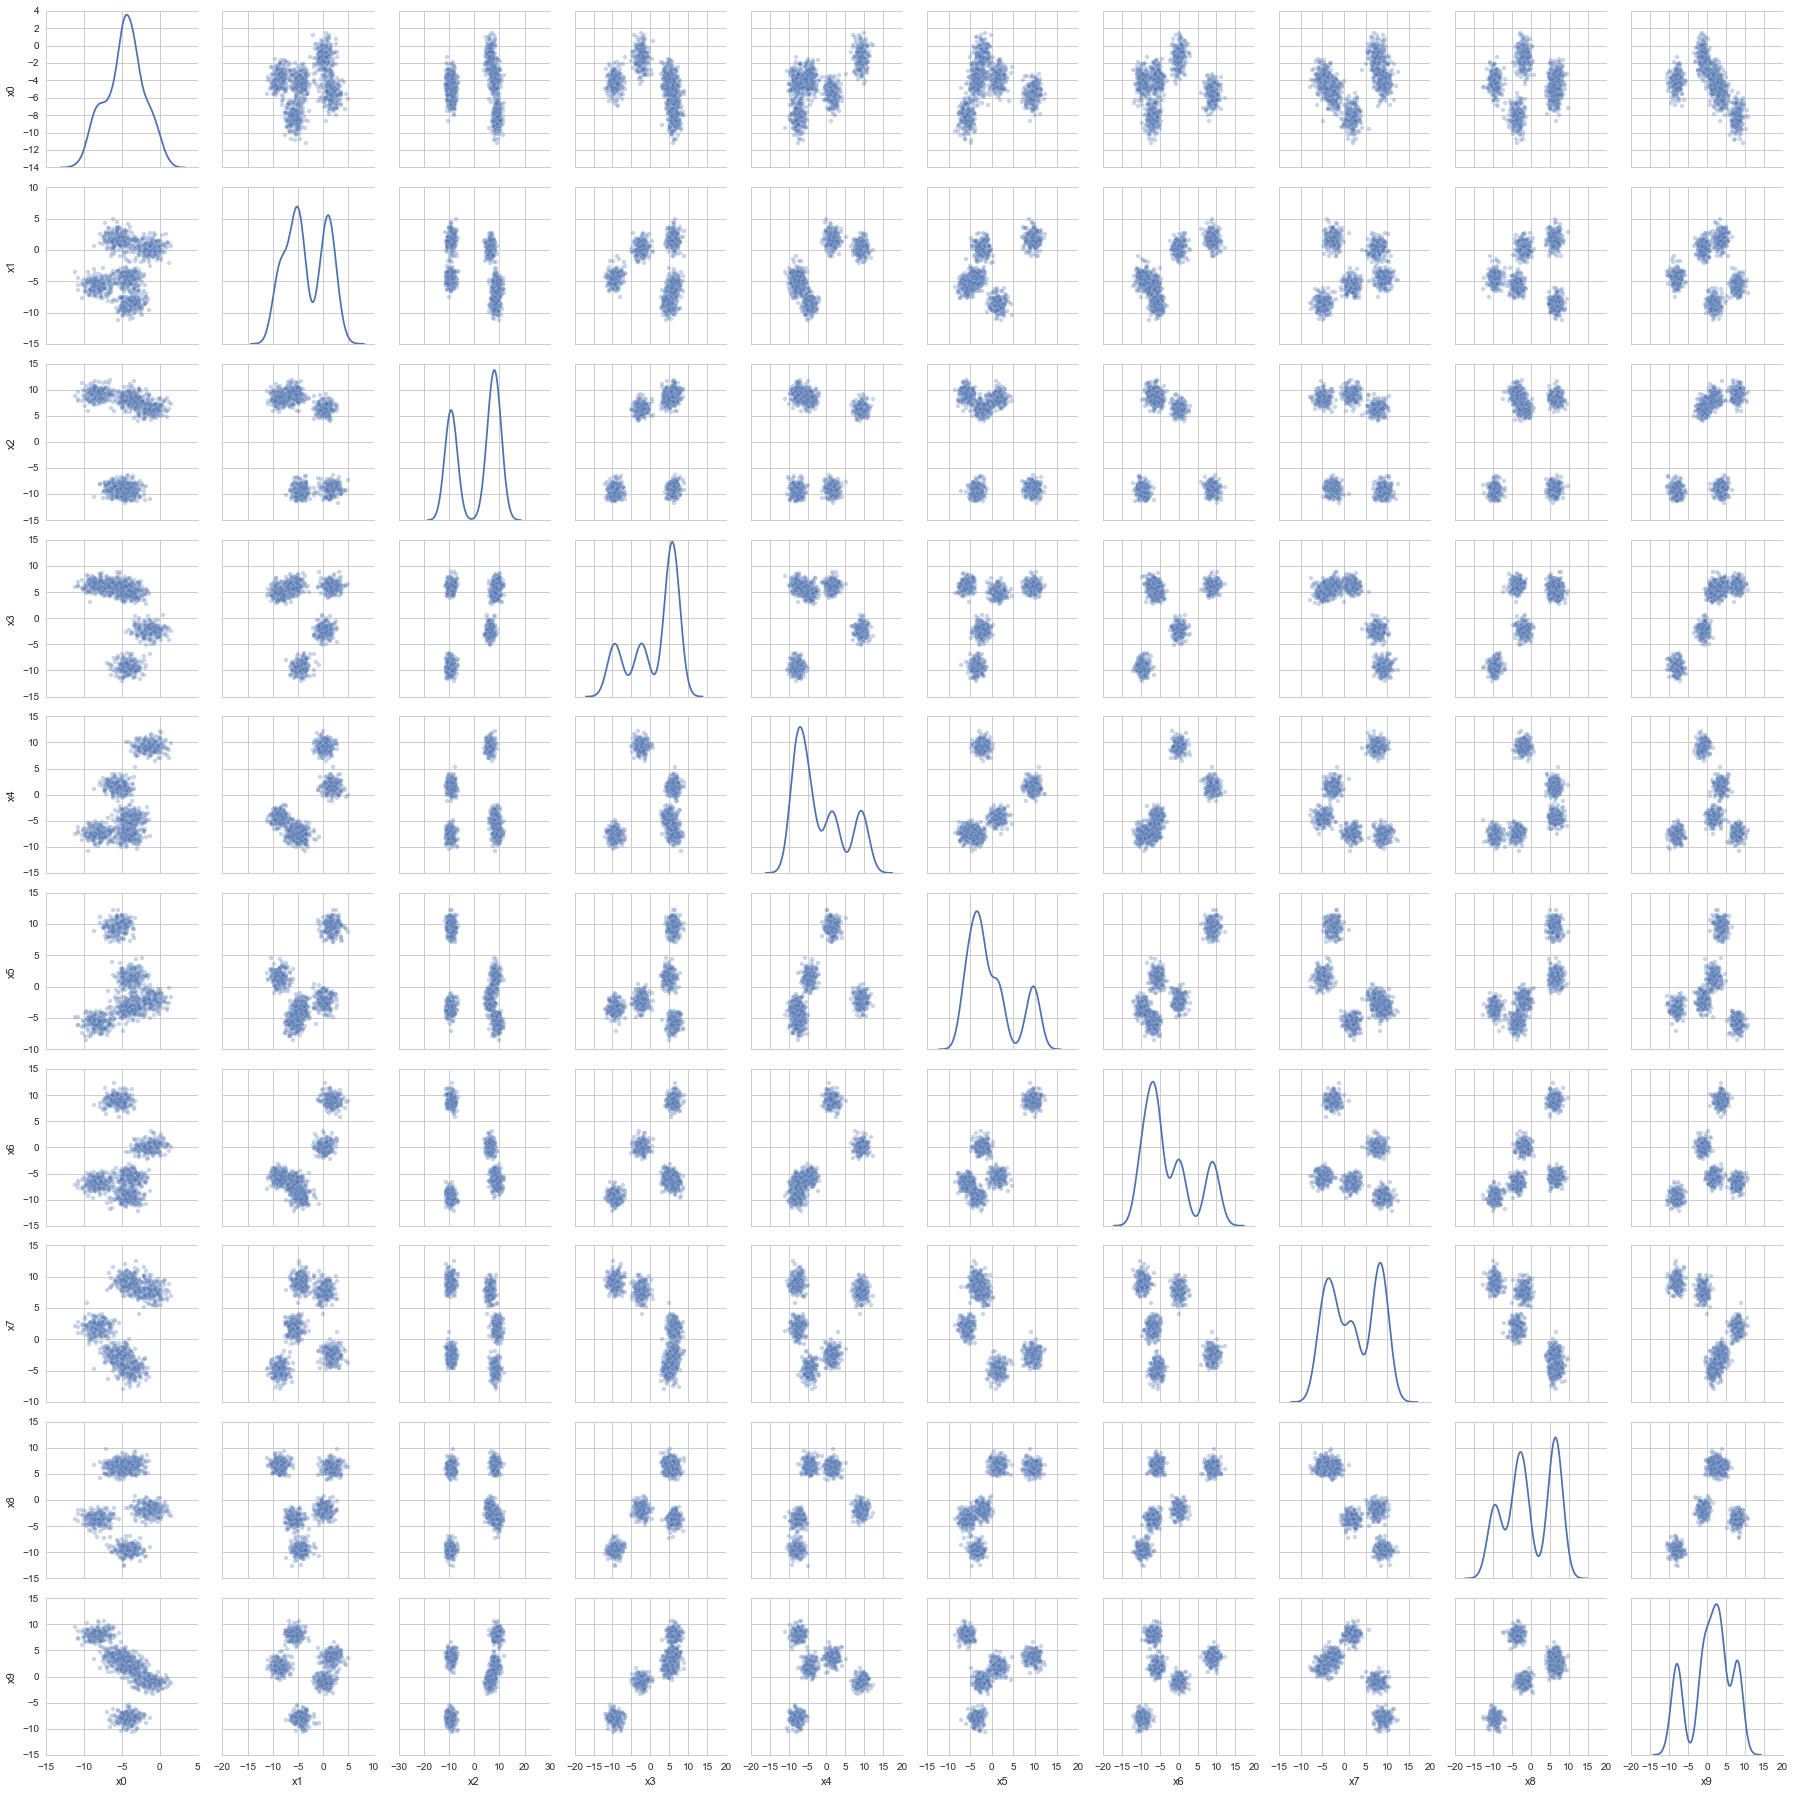

In [25]:
# this starts to take a few seconds when d~10
sns.pairplot(X_df_no_r, diag_kind='kde', plot_kws=dict(alpha=0.3))

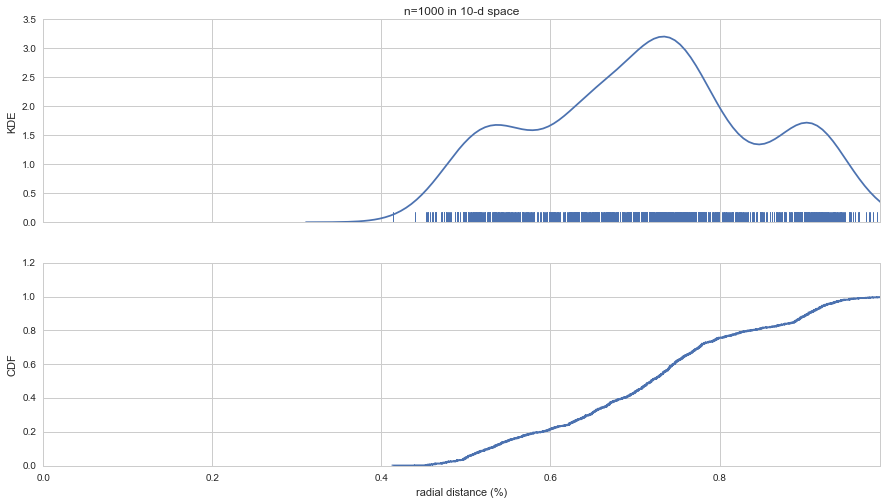

In [26]:
kde_cdf_plot(X_df, norm=True)

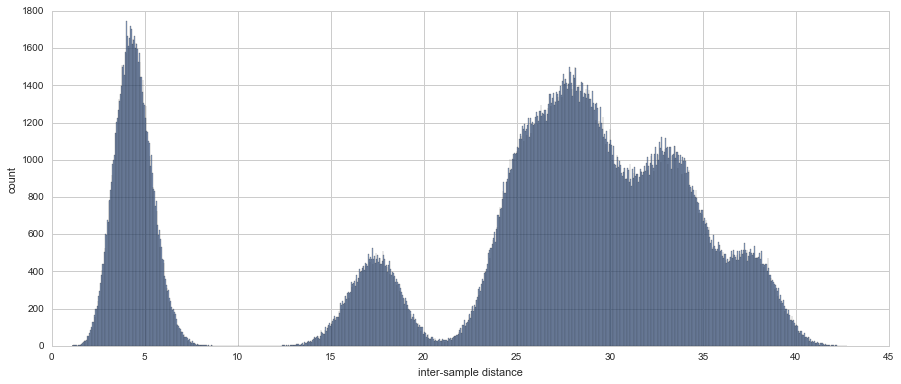

In [27]:
in_sample_dist(X,n)

Having seen the way these plots vary individually, let's compare, side-by-side, a similar data generation process (same number of points and clusters) in a range of dimensions.

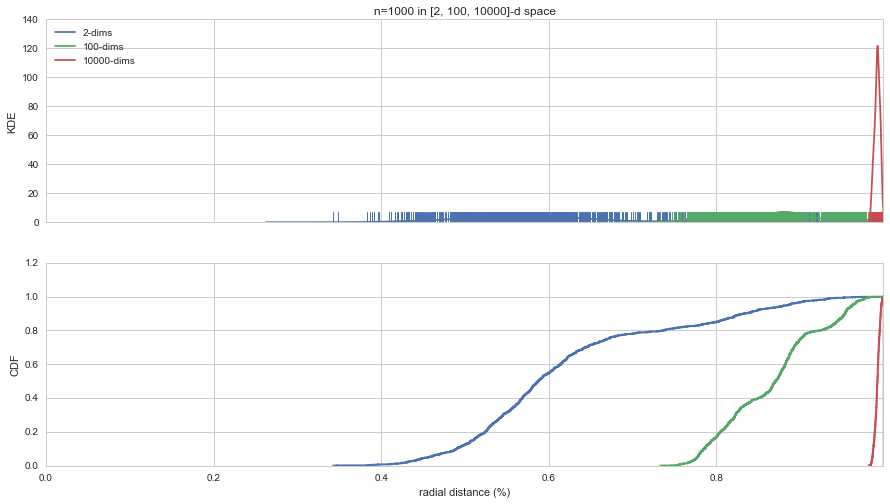

In [28]:
n_points = 1000
dim_range = [2, 100, 10000]
blob_count = 5


fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(15,8))

for d in dim_range:
    ## data generation    
    # random gaussian blobs in d-dims
    X, y = make_blobs(n_samples=n_points, n_features=d, centers=blob_count)
    ## 
    
    ## calculation
    # create a labeled df from X
    X_df = pd.DataFrame(X, columns=['x{}'.format(i) for i in range(X.shape[1])])
    # add an 'r' column
    #X_df_no_r = copy.deepcopy(X_df)
    X_df['r'] = X_df.apply(radius, axis=1)
    # normalize r value to % of max?
    X_df['r'] = X_df['r'] / max(X_df['r'])
    ##
    
    ## plotting
    # subplot 1 - KDE
    sns.distplot(X_df['r'], 
                 kde=True,
                 hist=False, 
                 rug=True, 
                 ax=ax1,
                 label='{}-dims'.format(d)
                )
    
    # subplot 2 - CDF
    X_df['r'].plot(kind='hist', 
                   cumulative=True, 
                   normed=1, 
                   bins=len(X_df['r']), 
                   histtype='step', 
                   linewidth=2,
                   ax=ax2
                  )
    ##
    

ax1.set_ylabel('KDE')
ax1.set_title('n={} in {}-d space'.format(len(X_df), dim_range) )
ax2.set_ylabel('CDF')

plt.xlim(0, .999*max(X_df['r']))    
plt.xlabel('radial distance (%)')

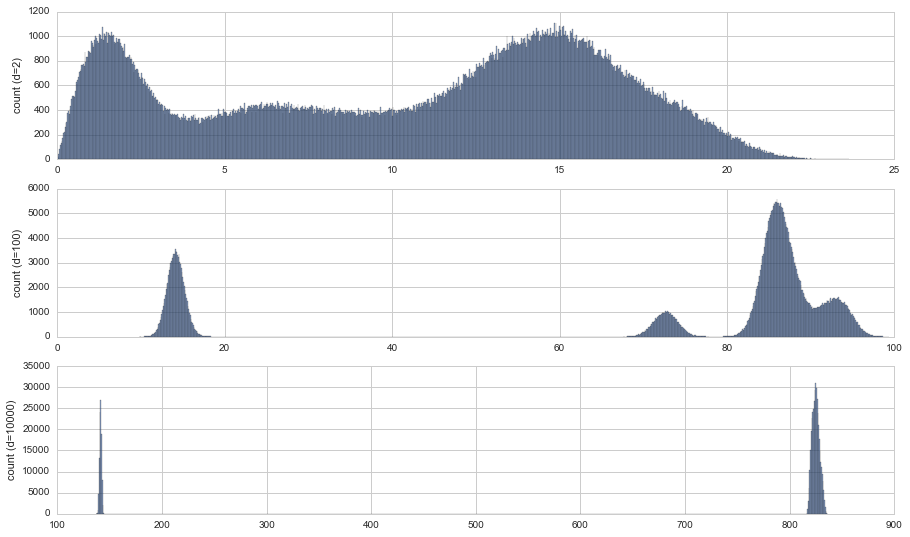

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,9))


for i,d in enumerate(dim_range):
    X, y = make_blobs(n_samples=n_points, n_features=d, centers=blob_count)
    
    # loop through the subplots
    plt.subplot('31{}'.format(i+1))
    # plot the data 
    plt.hist(spd.pdist(X), bins=n_points, alpha=0.6)
    plt.ylabel('count (d={})'.format(d))

ax3.set_xlabel('inter-sample distance')  

# Text data

Most of the time, our unsupervised clustering in high dimensions is a function of using text data as an input. We'll start with a small corpus - again, to build intuition about what the data looks like - and then work up.

In [30]:
small_corpus = [
    'The dog likes cats.',
    'The blue cat eats brown sharks.',
    'Why not, blue?'
]

In [31]:
vec = CountVectorizer()

X = vec.fit_transform(small_corpus)

X.todense()

matrix([[0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]], dtype=int64)

In [32]:
vec.vocabulary_

{'blue': 0,
 'brown': 1,
 'cat': 2,
 'cats': 3,
 'dog': 4,
 'eats': 5,
 'likes': 6,
 'not': 7,
 'sharks': 8,
 'the': 9,
 'why': 10}

It's good to remember how to map the matrix-like data onto the words that go into it...

In [33]:
terms = [x for x,_ in sorted(vec.vocabulary_.items(), key=operator.itemgetter(1))]

text_df = pd.DataFrame(X.todense(), columns=terms)

text_df

,blue,brown,cat,cats,dog,eats,likes,not,sharks,the,why
0,0,0,0,1,1,0,1,0,0,1,0
1,1,1,1,0,0,1,0,0,1,1,0
2,1,0,0,0,0,0,0,1,0,0,1


In [34]:
text_df['r'] = text_df.apply(radius, axis=1)

text_df

,blue,brown,cat,cats,dog,eats,likes,not,sharks,the,why,r
0,0,0,0,1,1,0,1,0,0,1,0,2.000000
1,1,1,1,0,0,1,0,0,1,1,0,2.449490
2,1,0,0,0,0,0,0,1,0,0,1,1.732051


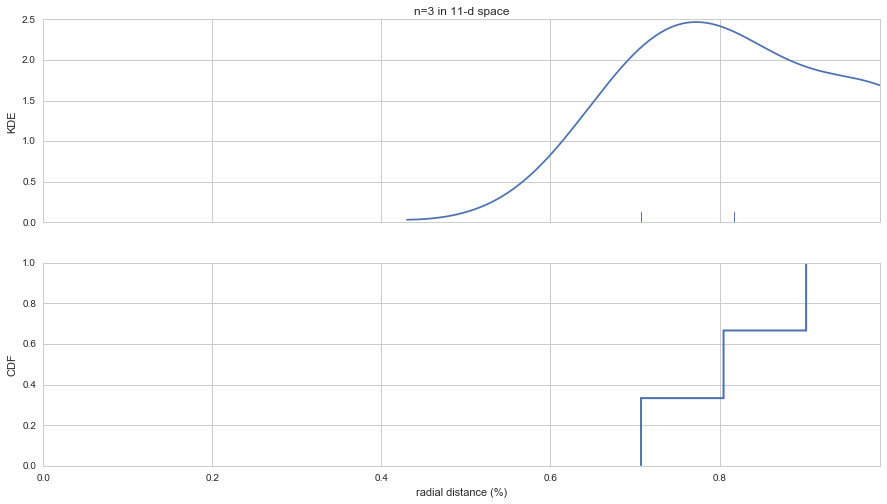

In [35]:
kde_cdf_plot(text_df, norm=True)

With a tiny little corpus, these plots aren't very useful. Let's use a bigger one: this text file (not included in the repo, sorry visitors!) is about a 10-minute, 10% sample of Tweet (body text) from the Firehose. It has a little under 400,000 Tweets.

In [36]:
text_array = []

with open('twitter_2016-04-06_2030.jsonl.body.txt', 'r') as infile:
    for line in infile:
        text_array.append(line.replace('\n', ' '))
        
print( len(text_array) )
print( text_array[0] )        

374941
@iamkuds omgg THANK YOU SO MUCH❤️❤️ 


In [37]:
vec = CountVectorizer(
                    #binary=1,
                    ## add dimensionality reduction?
                    #stop_words='english',
                    #lowercase=True,
                    #min_df=10
                    )

dtm = vec.fit_transform(text_array)

dtm

<374941x523498 sparse matrix of type '<class 'numpy.int64'>'
	with 3051924 stored elements in Compressed Sparse Row format>

In [38]:
# what fraction of the feature space is full?
3051924 / ( 374941*523498 )

1.5548759791171626e-05

We have to do the radius math slightly differently now, because we're dealing with a scipy CSR matrix instead of a dense numpy array.

In [39]:
#       (element-wise sq) (row sum) (flatten) (sqrt)
dtm_r = dtm.multiply(dtm).sum(axis=1).A1**0.5


#print(len(dtm_r))
#print(dtm_r)
#print(min(dtm_r), np.median(dtm_r), max(dtm_r))

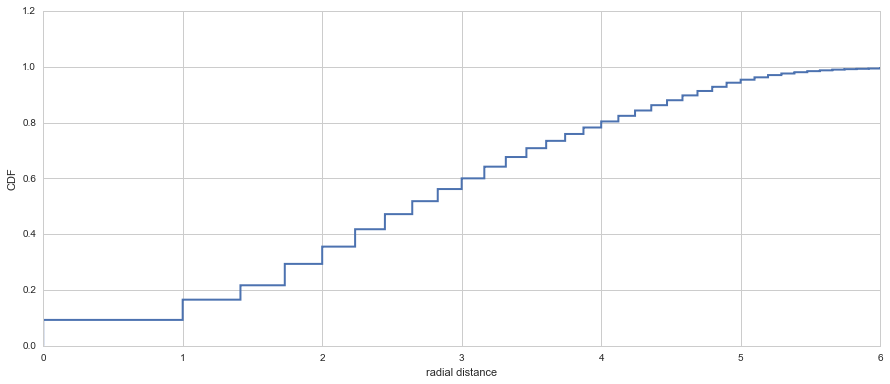

In [40]:
s = pd.Series(dtm_r)

plt.figure(figsize=(15,6))
s.plot(kind='hist', 
       cumulative=True, 
       normed=1, 
       bins=len(dtm_r), 
       histtype='step', 
       linewidth=2
      )

plt.ylabel('CDF')
#plt.xlim(0, .99*max(dtm_r))
plt.xlim(0, 6)
plt.xlabel('radial distance')

In [ ]:
# This is a super interesting side note: some tweets can totally throw off your distribution. 
# This one Tweet had 114 repetitions of a single character. If you swap the xlim() commands 
#  above, you'll see that r extends to over 100. This is why:
#text_array[ s[ s > 114 ].index[0] ]

## `<record-stopping screeching noise>` 

Ok, so I spent some time working with this data, and I'll be honest: I expected this distribution to be much more skewed to large `r`! In fact, I thought it would be *more* exaggerated than the blob examples above. 

Since I didn't have enough time to dig any deeper for this session, let's keep this observation in the back of our minds, and come back to it in another session. 

We can round out today's discussion with one more relevant topic...

# Dimensionality reduction

Before we end this session, we'll consider one more facet of high-dimensional spaces: reducing them to lower dimension. For now, we'll illustrate the effect of using principal component analysis using the same inspection techniques we've been using all along.

If we try to densify the 500k+ dimension document term matrix above, we'll run out of RAM. So, let's use a synthetic data set. 

First, we look at our metrics in 10,000 dimensions, then after PCA to bring them down to 3.

In [41]:
n = 2000
dims = 10000
blobs = 10


X, X_df, X_df_no_r, y = make_blob_df(n, dims, blobs)

#X_df_no_r.head()

(0, 1)

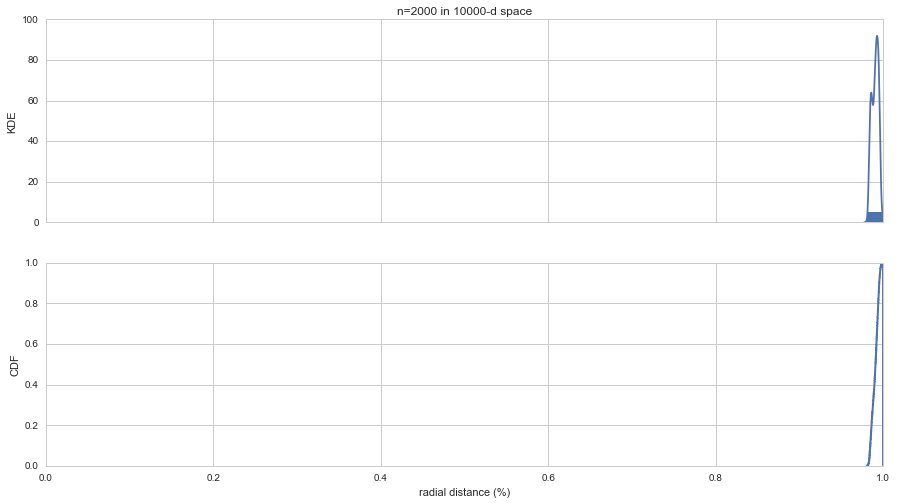

In [42]:
kde_cdf_plot(X_df, norm=True)
plt.xlim(0,1)

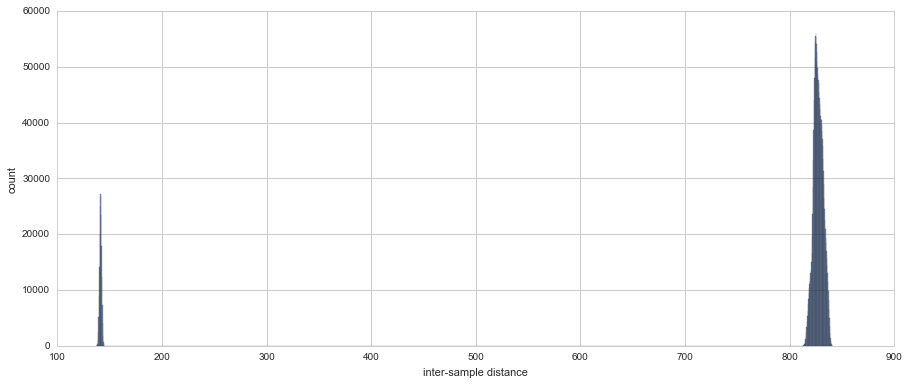

In [43]:
in_sample_dist(X,n)

Now, we know that the data generation process built in the notion of identifiable clusters. Let's see if we can surface that information by projecting our high-dimensional data and space down into a smaller number using principal component analysis.

In [44]:
# now apply PCA and reduce the dimension down to 3
pca = PCA(n_components=3)

X_df_3d = pd.DataFrame(pca.fit_transform(X_df_no_r), columns=['x0','x1','x2'])

In [45]:
# add in that radial distance column
X_df_3d['r'] = X_df_3d.apply(radius, axis=1)

X_df_3d.head()

,x0,x1,x2,r
0,-118.453202,-67.608246,318.139357,346.142581
1,-118.176223,-68.608370,315.677054,343.983620
2,-9.561771,-423.084875,-48.500582,425.963080
3,-219.201697,107.419963,-44.354848,248.104383
4,376.022467,174.300821,85.655181,423.214463


In [46]:
# add in the labels so we can color by them
X_df_3d['y'] = y

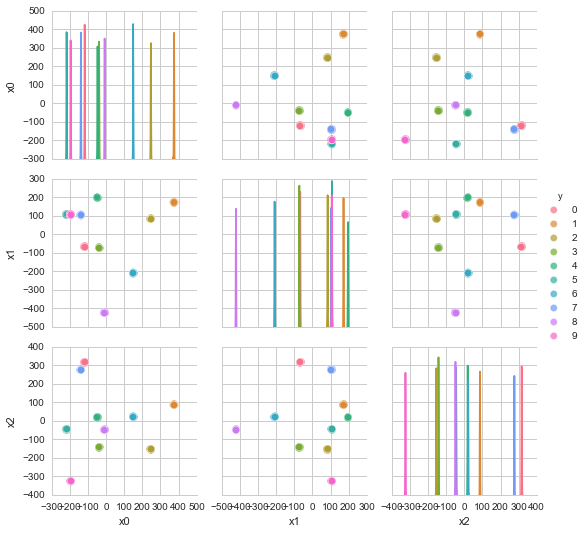

In [47]:
# nb: using the vars kwarg seems to remove the ability to include KDE
sns.pairplot(X_df_3d, 
             vars=['x0','x1','x2'], 
             hue='y', 
             palette="husl",
             diag_kind='kde',  
             plot_kws=dict(s=50, alpha=0.7)
            )

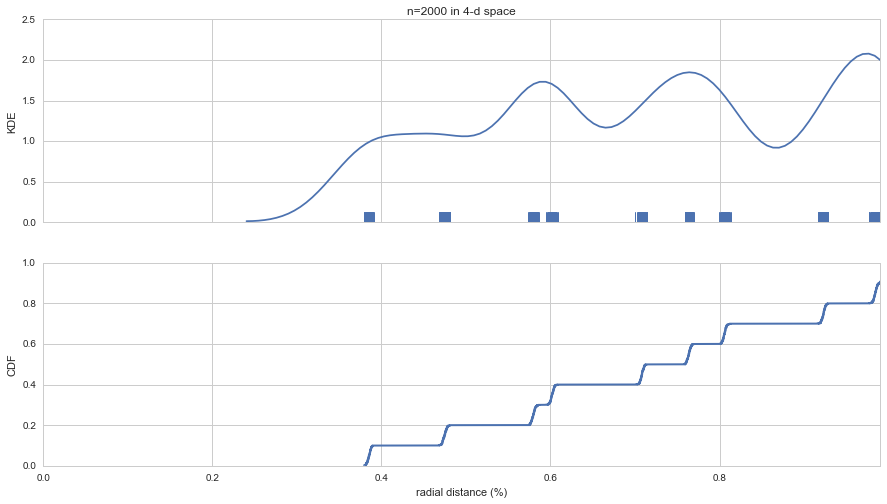

In [48]:
kde_cdf_plot(X_df_3d, norm=True)

In [ ]:
#in_sample_dist(X_df_3d[['x0','x1','x2']],n)

Given the two plots just above, it seems like we've both done a good job of representing the underlying clusters in our lower-dimensional space, and moved the data away from the extreme edges of the feature space. We should expect that both our algorithms can run more efficiently (faster), and achieve a higher level of significance.

## Still to come...

In future installments, I look forward to:

- a deeper understanding of our typical high-dimensional text feature space 
- strategies for dealing with distance calculations in high dimensions
- ... probably some other stuff, too...